In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/C_edit.csv")
df.head()

,sequence,edit_positions
0,TGTAGTTTCCGCCGCGTTTATGGCCGCGTTAAGTCTGAGTGCCGCT...,"[1481, 1547, 5044, 5057, 151013, 152476, 17046..."
1,CAAAGCCACCCTGGGTCACCTACATACTAAGGGAATAAACGCCACT...,[425]
2,ACTGTGGCTCCCGAAGCTGCTTCGGGCCCCAGCGGTGAGGAAGAAG...,"[529, 8621, 8648, 8658, 22156, 33299, 44351, 7..."
3,AGAATTTCGTCAAAGTCTGGTCCGACGTAACCCTCTCGGGAAATCC...,"[16072, 26659]"
4,AAAATCTTATAAGTAGTTTCGAAATAAATATTAACAAGGTTTGACC...,"[5045, 5164]"


## making n-grams

In [ ]:
from itertools import product
import numpy as np


def generate_dna_ngrams(k1, k2):
    ngrams = []
    for k in range(k1, k2+1):
        kgrams = [''.join(gram) for gram in product('GATC', repeat = k)]
        ngrams.append(kgrams)
    return np.concatenate(ngrams)

In [ ]:
from collections import defaultdict

def count_ngrams(sequence, dna_ngrams):
    ngram_counts = defaultdict(int)

    for ngram in dna_ngrams:
        ngram_counts[ngram] = sequence.count(ngram)

    return ngram_counts

In [ ]:
w = 50  # number nucleotides to the left and right of C
k1 = 2  # min ngram
k2 = 4  # max ngram

dna_ngrams = generate_dna_ngrams(k1, k2)

def get_ngrams_vector(sequence, pos, w, dna_ngrams):
    # counting dna ngrams
    left_dict = count_ngrams(sequence[pos-w:pos], dna_ngrams)
    right_dict = count_ngrams(row["sequence"][pos+1:pos+w+1], dna_ngrams)

    left_array = list(left_dict.values())
    right_array = list(right_dict.values())

    return left_array + right_array

In [ ]:
import ast


X = []  # left-right ngrams counts
y = []  # C-edit class, 0 for not edited 1 for edited

for index, row in df.iterrows():
    # edited C
    edit_positions = ast.literal_eval(row["edit_positions"])
    for c_pos in edit_positions:
        vector = get_ngrams_vector(row["sequence"], c_pos, w, dna_ngrams)
        X.append(vector)
        y.append(1)  # class: edited

    l = len(row["sequence"])  # length of dna sequence

    # Undersampling: subset of non-edited C
    i = 51
    while i < l:
        if row["sequence"][i] == "C" and l-i > w and i not in edit_positions:
            vector = get_ngrams_vector(row["sequence"], i, w, dna_ngrams)
            X.append(vector)
            y.append(0)  # class: non-edited

            i += 500  # Skipping some dna
        else:
            i += 1

In [ ]:
X = X[:200000]
y = y[:200000]

In [ ]:
import pickle

# Storing data
with open('/content/drive/My Drive/data/ngrams_X2.pkl', 'wb') as f:
  pickle.dump(X, f)

with open('/content/drive/My Drive/data/ngrams_y2.pkl', 'wb') as f:
  pickle.dump(y, f)

## Training downstream model

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
# Loading data from drive
with open('/content/drive/My Drive/data/ngrams_X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('/content/drive/My Drive/data/ngrams_y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Instantiate the RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=0)

# Fit and transform the training data
X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [ ]:
!pip install lightgbm

import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

clf = lgb.LGBMClassifier(**params)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 14587, number of negative: 14587
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.280569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4485
[LightGBM] [Info] Number of data points in the train set: 29174, number of used features: 672
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Accuracy: 0.64


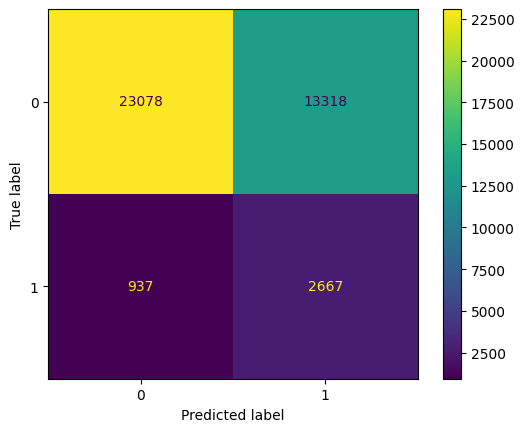

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, y_pred, labels= [0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


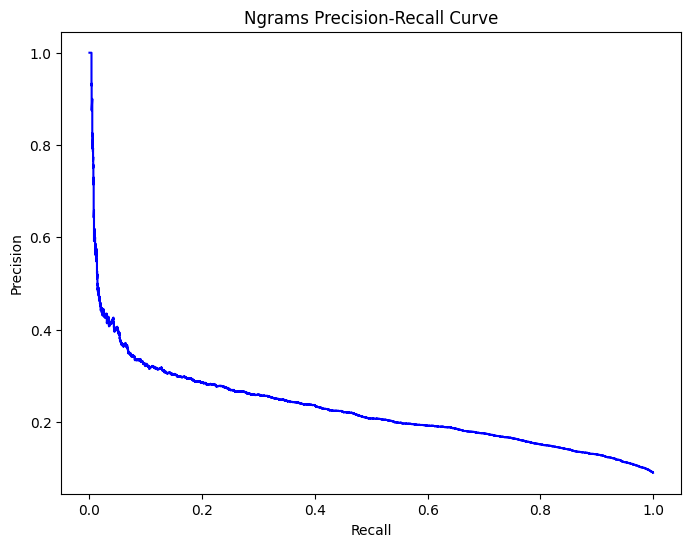

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Calculate precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Ngrams Precision-Recall Curve')
plt.show()

In [ ]:
with open('/content/drive/My Drive/data/ngrams_recall_precision.pkl', 'wb') as f:
  pickle.dump([recall, precision], f)